In [1]:
import torch
import numpy as np
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from nn_model_block import FieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 16
volume = lattice_size ** 2
beta = 5
n_thermalization_steps = 200
n_steps = 50
step_size = 0.1
n_iterations = 512

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Set default type
torch.set_default_dtype(torch.float32)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Thermalizing:   0%|          | 0/200 [00:00<?, ?it/s]

Running HMC: 100%|██████████| 512/512 [00:05<00:00, 92.19it/s]


>>> Simulation completed


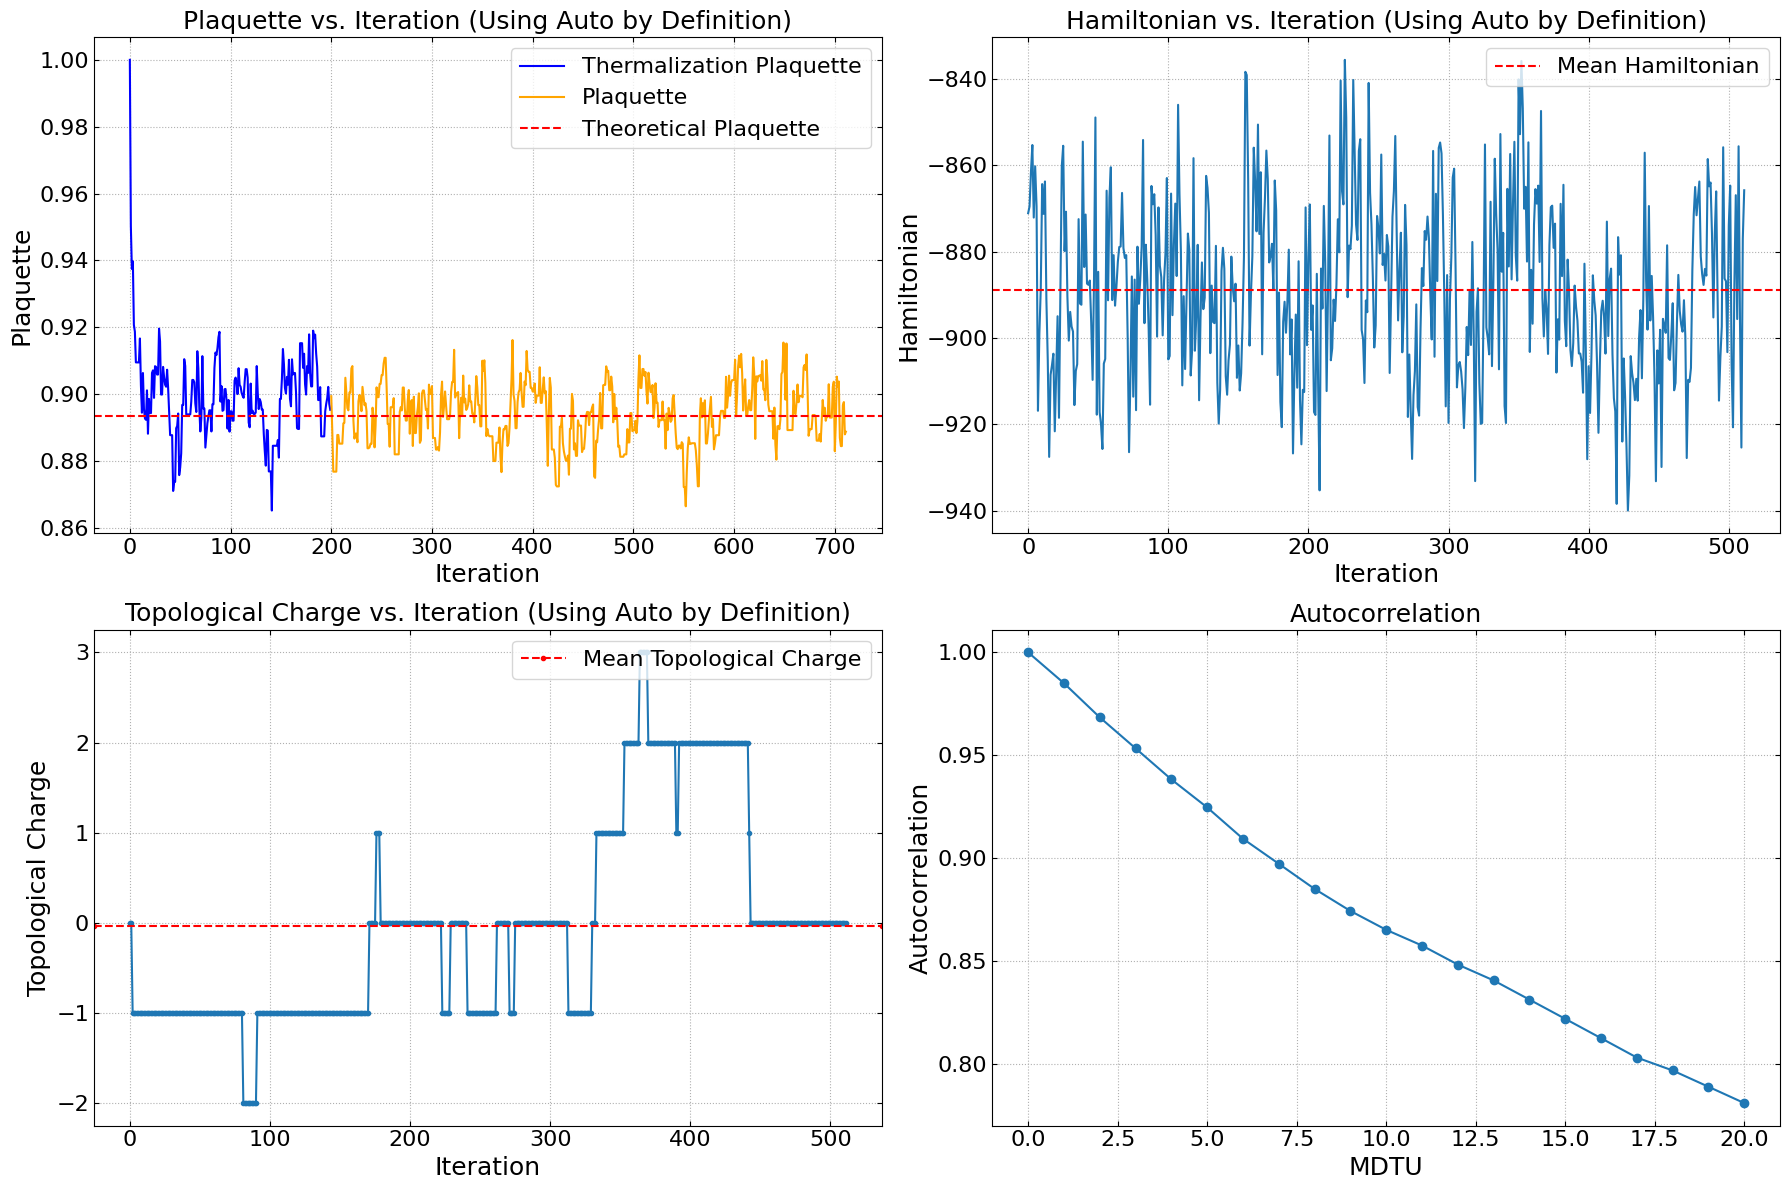

>>> Theoretical plaquette:  0.8933831370440852
>>> Mean plaq:  0.8940275878412649
>>> Std of mean plaq:  0.00038708332705635545
Thermalization acceptance rate: 0.8150
Acceptance rate: 0.7637


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
config_ls, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

# Save configurations for training
np.save('dump/theta_ori.npy', torch.stack(config_ls).detach().cpu().numpy())


### Neural Network Field Transformation

In [4]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# initialize the field transformation
nn_ft = FieldTransformation(lattice_size, device=device)

# load the data
data = np.load('dump/theta_ori.npy')
tensor_data = torch.from_numpy(data).float().to(device)
print(f"Loaded data shape: {tensor_data.shape}")

# split the data into training and testing
train_size = int(0.1 * len(tensor_data))
train_data = tensor_data[:train_size]
test_data = tensor_data[train_size:]
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# train the model
print(">>> Training the model")
nn_ft.train(train_data, test_data, beta, n_epochs=50, batch_size=4)

# Save the trained model
print(">>> Saving the trained model")
torch.save(nn_ft.model.state_dict(), 'models/cnn_block_trained.pt')
print(">>> Model saved successfully")


# Load the trained model
print(">>> Loading the trained model")
nn_ft.model.load_state_dict(torch.load('models/cnn_block_trained.pt'))
nn_ft.model.eval()
print(">>> Model loaded successfully")


field_transformation = nn_ft.field_transformation

# Initialize HMC with field transformation
n_thermalization_steps = 50
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=field_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

>>> Neural Network Field Transformation HMC Simulation: 
Loaded data shape: torch.Size([512, 2, 16, 16])
Training data shape: torch.Size([51, 2, 16, 16])
Testing data shape: torch.Size([461, 2, 16, 16])
>>> Training the model


Training epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training epochs:   0%|          | 0/50 [29:03<?, ?it/s]


KeyboardInterrupt: 